# 01 | NLP Model Train

The objective of this notebook is to train an NLP classifier to assign labels to clinical notes.

### What I did
The data augmentation process, implemented in **00_data_augmentation.ipynb**, was designed to enhance the dataset by generating new text samples using techniques such as random deletion, random insertion, word shuffling, and synonym replacement.

I applied several strategies to improve model performance across two scenarios:

* Training without Data Augmentation – Using the original dataset.
* Training with Data Augmentation – Incorporating the augmented data generated in 00_data_augmentation.

The strategies applied in both cases include:

* Undersampling: To balance class distributions and reduce bias toward the majority classes.
* Grid Search and Cross-Validation: To optimize hyperparameters.
* One-Hot Encoding: To effectively handle categorical variables. (did not help)

The data augmentation approach led to an average performance improvement of 2% in precision, recall, and F1-score compared to the baseline dataset.

---

#### Thoughts
Without *good data* it is difficult to have a performing model, so I thought of using a simple model that is fed with good data. 
The advantage on my side is that I can train it in a very short time and with a computer without a gpu while maintaining a decent performance for what is the task and the time of this assignment.

## 0 | Setup

### 0.1 | Install dependencies

In [2]:
!pip3 install -q pandas
!pip3 install -q numpy
!pip3 install -q seaborn
!pip3 install -q matplotlib
!pip3 install -q scikit-learn
!pip3 install datasets -q


In [3]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## 1 | Data Exploration

Here we see the unbalanced distribution of the *Original Dataset* and the new distribution after *Data Augmentation* (with 00_data_augmentation.ipynv)

In [4]:
import pandas as pd

df = pd.read_csv("./train/train_data.csv")

df_original = pd.read_csv("./train/train_data.csv")
df_augmented = pd.read_csv("./train/train_data_aug.csv")
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)

print("\nCategory counts (Original):")
print(df_original['domain'].value_counts())

print("\nCategory counts in (Original + Augmented):")
print(df_combined['domain'].value_counts())


Category counts (Original):
domain
Orthopedic          203
Radiology           168
Gastroenterology    137
Neurology           123
Urology              95
Name: count, dtype: int64

Category counts in (Original + Augmented):
domain
Orthopedic          406
Radiology           336
Gastroenterology    274
Neurology           246
Urology             190
Name: count, dtype: int64


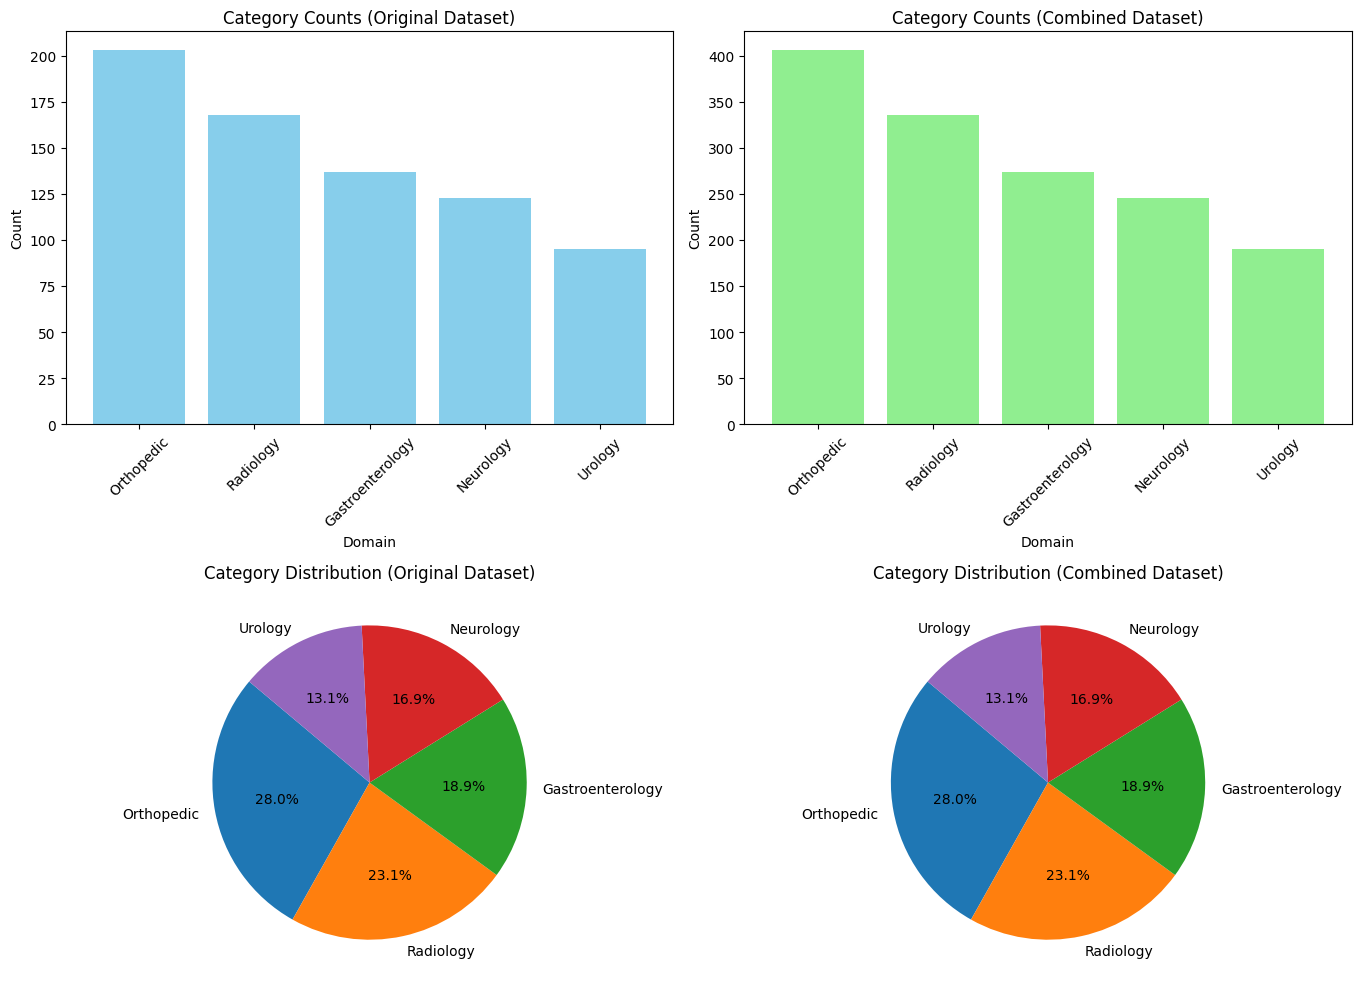

In [5]:
import matplotlib.pyplot as plt

# Count categories
original_counts = df_original['domain'].value_counts()
combined_counts = df_combined['domain'].value_counts()

# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bar plot for original dataset
axes[0, 0].bar(original_counts.index, original_counts.values, color='skyblue')
axes[0, 0].set_title("Category Counts (Original Dataset)")
axes[0, 0].set_xlabel("Domain")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis='x', rotation=45)

# Bar plot for combined dataset
axes[0, 1].bar(combined_counts.index, combined_counts.values, color='lightgreen')
axes[0, 1].set_title("Category Counts (Combined Dataset)")
axes[0, 1].set_xlabel("Domain")
axes[0, 1].set_ylabel("Count")
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie chart for original dataset
axes[1, 0].pie(original_counts, labels=original_counts.index, autopct='%1.1f%%', startangle=140)
axes[1, 0].set_title("Category Distribution (Original Dataset)")

# Pie chart for combined dataset
axes[1, 1].pie(combined_counts, labels=combined_counts.index, autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title("Category Distribution (Combined Dataset)")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## 2 | Data preparation

Utils functions that help me do some standard text **pre-processing** (to avoid *noise* in the data) and **data loading**

In [6]:
from typing import Optional, Dict
import os
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[\x00-\x1F\x7F]', '', text)
    text = re.sub(r'\s+([.,:;])', r'\1', text)
    return text

def load_documents(df: pd.DataFrame, directory: Optional[str]) -> Dict[str, str]:
    if not directory:
        return {}

    text_data = {}
    for _, row in df.iterrows():
        file_path = os.path.join(directory, row['file_name'])
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                text_data[row['file_name']] = file.read()
        except UnicodeDecodeError:
            with open(file_path, "r", encoding="latin1") as file:  # Fallback encoding
                text_data[row['file_name']] = file.read()

    return text_data

def load_dataset(train_data_path: str = "./train/train_data.csv",
                 train_augmented_path: Optional[str] = None, # "./train/train_data_aug.csv"
                 notes_dir: str = "./train/notes/",
                 augment_dir: Optional[str] = None, # "./train/augment/"
                 train_manual_path: Optional[str] = None,  # "./train/train_data_aug_manual.csv"
                 manual_dir : Optional[str] = None, # "./train/augment_manual/"
                 ) -> pd.DataFrame:
    """
    Load and preprocess the dataset from CSV files and corresponding text files.

    Args:
        train_data_path (str): Path to the original training CSV file.
        train_augmented_path (Optional[str]): Path to the augmented training CSV file. If None, augmentation is skipped.
        notes_dir (str): Directory containing original text files.
        augment_dir (Optional[str]): Directory containing augmented text files. If None, augmented text files are not loaded.

    Returns:
        pd.DataFrame: A DataFrame containing (file_name, domain, text, cleaned_text)
    """

    df_original = pd.read_csv(train_data_path)
    df_augmented = pd.read_csv(train_augmented_path) if train_augmented_path and augment_dir else pd.DataFrame(columns=df_original.columns)
    df_manual = pd.read_csv(train_manual_path) if train_manual_path and manual_dir else pd.DataFrame(columns=df_original.columns)
    df_combined = pd.concat([df_original, df_augmented, df_manual], ignore_index=True)

    text_data_original = load_documents(df_original, notes_dir)
    text_data_augmented = load_documents(df_augmented, augment_dir) if not df_augmented.empty and augment_dir else {}
    text_data_manual = load_documents(df_manual, manual_dir) if not df_manual.empty and manual_dir else {}
    text_data_combined = {**text_data_original, **text_data_augmented, **text_data_manual}

    df_combined['text'] = df_combined['file_name'].map(text_data_combined)
    df_combined['cleaned_text'] = df_combined['text'].apply(preprocess_text)

    return df_combined

## 3 | Train and Test

### 3.1 | Without Data Augmentation

                  precision    recall  f1-score   support

Gastroenterology       1.00      0.80      0.89        10
       Neurology       0.45      0.50      0.48        10
      Orthopedic       0.73      0.80      0.76        10
       Radiology       0.50      0.50      0.50        10
         Urology       0.90      0.90      0.90        10

        accuracy                           0.70        50
       macro avg       0.72      0.70      0.71        50
    weighted avg       0.72      0.70      0.71        50



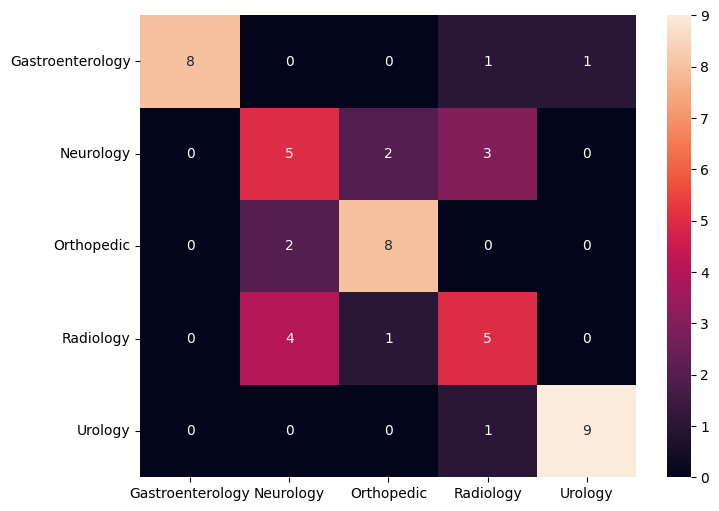

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = load_dataset(
    train_data_path= "./train/train_data.csv",
    notes_dir="./train/notes/",
) # Dimension (file_name, domain, text, cleaned_text)

# Extracting relevant textual features using TF-IDF with up to 4-grams, limiting to the top 5000 features to balance performance and model complexity.
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 4))
X = tfidf.fit_transform(train_df['cleaned_text'])
y = train_df['domain']

# TRAIN
model = LogisticRegression(class_weight='balanced')
model.fit(X, y)

# EVALUATE
test_df = load_dataset("./test/test_data.csv",notes_dir="./test/notes/")

X_test = tfidf.transform(test_df['cleaned_text'])
y_pred = model.predict(X_test)

print(classification_report(test_df['domain'], y_pred))

labels = sorted(test_df["domain"].unique())
cm = confusion_matrix(test_df["domain"], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.show()

#### (Note) Heatmap

* **Rows** represent the actual labels (true domain).

* The **columns** represent the labels predicted by the model.

* The **numbers in the cells** indicate how many times an instance has been classified in a specific category.

* **Main diagonal (top left to bottom right)**: These are the correct values, where the prediction coincides with reality.

* **Off Diagonal**: These are classification errors.

### 3.2 | With Data Augmentation

                  precision    recall  f1-score   support

Gastroenterology       1.00      0.80      0.89        10
       Neurology       0.56      0.50      0.53        10
      Orthopedic       0.75      0.90      0.82        10
       Radiology       0.45      0.50      0.48        10
         Urology       0.90      0.90      0.90        10

        accuracy                           0.72        50
       macro avg       0.73      0.72      0.72        50
    weighted avg       0.73      0.72      0.72        50



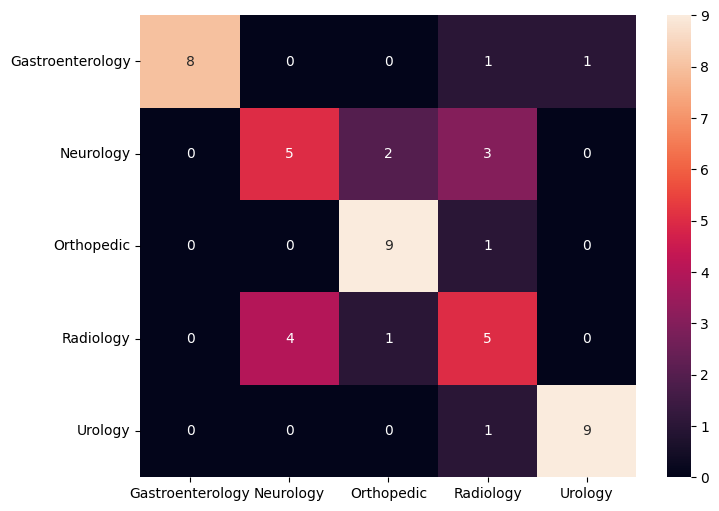

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = load_dataset(
    train_data_path= "./train/train_data.csv",
    train_augmented_path="./train/train_data_aug.csv",
    notes_dir="./train/notes/",
    augment_dir="./train/augment/",
    #train_manual_path="./train/train_data_aug_manual.csv",
    #manual_dir ="./train/augment_manual/"
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 4))
X = tfidf.fit_transform(train_df['cleaned_text'])
y = train_df['domain']

# TRAIN
# I found better results by using class weight balancing instead of undersampling and balancing the classes
model = LogisticRegression(class_weight="balanced")
model.fit(X, y)

# EVALUATE
test_df = load_dataset("./test/test_data.csv",notes_dir="./test/notes/")

X_test = tfidf.transform(test_df['cleaned_text'])
y_pred = model.predict(X_test)

print(classification_report(test_df['domain'], y_pred))

labels = sorted(test_df["domain"].unique())
cm = confusion_matrix(test_df["domain"], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.show()


#### (Note) Heatmap

* **Rows** represent the actual labels (true domain).

* The **columns** represent the labels predicted by the model.

* The **numbers in the cells** indicate how many times an instance has been classified in a specific category.

* **Main diagonal (top left to bottom right)**: These are the correct values, where the prediction coincides with reality.

* **Off Diagonal**: These are classification errors.


#### Performance breakdown

* **Gastroenterology**: Precision of 1.00 indicates perfect classification of this class, but the recall of 0.80 suggests some missed cases. This means that while all predicted instances of this class are correct, not all actual cases of Gastroenterology were identified by the model.

* **Neurology**: Both precision and recall are relatively low (0.56 and 0.50, respectively), leading to a modest F1-score of 0.53. This suggests that the model struggles to correctly identify Neurology cases and also tends to misclassify other classes as Neurology.

* **Orthopedic**: The model performs well in this category, with precision and recall values of 0.75 and 0.90, respectively, leading to a strong F1-score of 0.82. It correctly identifies Orthopedic cases while also maintaining a reasonable number of misclassifications.

* **Radiology**: Precision and recall are both low at 0.45 and 0.50, resulting in a weak F1-score of 0.48. This indicates that the model is having significant difficulty in distinguishing Radiology cases from others.

* **Urology**: The performance is very strong in this category, with precision, recall, and F1-score all being high at 0.90. The model is very accurate in identifying Urology cases.

The overall accuracy of 0.72 reflects the model's average performance across all classes. The macro average and weighted average both show a similar trend, suggesting that while the model performs well in some classes (e.g., Gastroenterology, Orthopedic, and Urology), it struggles in others (Neurology and Radiology). This disparity highlights the need for potential improvements, such as better feature extraction, model refinement, or more data, especially for the poorly performing classes.

### 3.3 | Save Model
Save the *model* and the *vectorizer* in the folder of /api folder

In [9]:
import joblib

joblib.dump(model, './api/src/controller/ml/logistic_model.pkl')
joblib.dump(tfidf, './api/src/controller/ml/tfidf_vectorizer.pkl')

['./api/src/controller/ml/tfidf_vectorizer.pkl']

---

<br>
<br>
<br>

## 4 | Considerations

### 4.1 | Choice of Model
As mentioned at the beginning of this notebook, the decision to avoid more complex models, such as autoencoders, in favor of simpler approaches like Logistic Regression is driven by data availability. Logistic Regression can achieve reasonable performance with significantly fewer data compared to autoencoders.

In scenarios with limited data, data augmentation becomes a crucial strategy. Training a lightweight model can be particularly advantageous, as it reduces computational requirements while still enabling effective learning. This approach allows for faster experimentation and optimization, which is valuable when dealing with specialized domains like medical document classification.

### 4.2 | Additional Tests
I tried training a BERT model, but it became clear that more data is needed to achieve meaningful results with this model. BERT, being a large and complex model, requires a substantial amount of data to fully leverage its potential. In the current setting with limited data, the performance did not meet expectations, highlighting the need for more extensive datasets to make full use of its capabilities.

### 4.3 | Pain points (Weakness and Improvements)
Initially, I assumed that a straightforward data augmentation strategy would lead to a significant improvement in model performance compared to training solely on the original dataset. However, the actual results showed only a marginal performance increase.

Upon deeper analysis, I identified potential data gaps specifically within the Neurology and Radiology classes—an unexpected finding, as I initially anticipated more significant issues in the Urology class, given its smaller sample size.

In the time spent in this assignment, I wasn't able to pinpoint the exact cause of this discrepancy. 

However, I believe this requires further investigation. A potential approach is adopting a hybrid feature extraction method to better capture the semantics of medical documents, such as:
* Curating domain-specific vocabularies tailored to each medical specialty to enhance contextual understanding.
* Combining traditional techniques like Bag of Words (BoW) with more advanced methods to leverage both frequency-based patterns and semantic relationships, particularly for specialized medical terminology.

In the literature, I came across an interesting article such as [Zhou et al. (2017)](https://link.springer.com/article/10.1186/s12911-017-0556-8), where a hybrid approach combining rule-based methods and machine learning was successfully applied to improve feature extraction and classification of clinical notes. In this case, the following classes were used: Cardiology, Gastroenterology, Neurology, Oncology, Psychiatry, and Surgery. The combination of rule-based techniques and machine learning seems to be an effective approach for handling domain-specific clinical data.



<br>
<br>
<br>

---

<br>
<br>
<br>

### (draft tests) Grid Search in order to find best set of parameters

In [10]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report

# train_df = load_dataset(
#     train_data_path= "./train/train_data.csv",
#     train_augmented_path="./train/train_data_aug.csv",
#     notes_dir="./train/notes/",
#     augment_dir="./train/augment/"
# )

# param_grid = {
#     'vectorizer__max_features': [1000, 5000, 10000],
#     'vectorizer__ngram_range': [(1, 2), (1, 4), (1, 8)],
#     'vectorizer__min_df': [1, 2],
#     'vectorizer__max_df': [0.85, 1.0],
#     'model__solver': ['liblinear', 'saga'],
#     'model__penalty': ['l2'],
#     'model__class_weight': ['balanced']
# }

# model = LogisticRegression(class_weight='balanced')
# vectorizer = TfidfVectorizer()

# pipeline = Pipeline([
#     ('vectorizer', vectorizer),
#     ('model', model)
# ])

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
# grid_search.fit(train_df['cleaned_text'], train_df['domain'])

# print("Best parameters:", grid_search.best_params_)

# best_model = grid_search.best_estimator_

# # Valutazione sul dataset di test
# test_df = load_dataset("./test/test_data.csv", notes_dir="./test/notes/")
# X_test = test_df['cleaned_text']
# y_pred = best_model.predict(X_test)

# print(classification_report(test_df['domain'], y_pred))
